# Replicate: MobileSAM 
### onnxruntime-gpu (.onnx)
conda activate MobileSAM_onnx
July 28th

In [1]:
# New conda env

"""
# clean env wipe & activate
conda env remove --name mobilesam_py310 -y
conda create -n MobileSAM_onnx python=3.10 -y
conda activate MobileSAM_onnx

sudo apt update
sudo apt install libcudnn8 libcudnn8-dev
conda install -c conda-forge libstdcxx-ng=12 -y

# Instalation of MobileSAM repo requirements

pip install git+https://github.com/ChaoningZhang/MobileSAM.git

# pip install -r requirements.txt
# python setup.py install
pip install timm==1.0.17 ultralytics==8.0.120 matplotlib==3.5.3 'opencv-python<4.9' jetson-stats



# typical np version mismatch
pip uninstall -y numpy
pip install "numpy>=1.19.2,<2.0"
# pip install numpy==1.26.4 

# Now install the CUDA PyTorch 2.5.0a0 (compatible with jp61 torch)
pip install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl

# download torchvision 0.20.0a0 (compatible with jp61 torch)
cd ~/vision/
python3 setup.py install
cd ~

# Install ONNX runtime (REPO INSTRUCTIONS: We recommend to use onnx==1.12.0 onnxruntime==1.13.1 which is tested)
pip install onnx==1.13.1 onnxruntime==1.13.1 

"""

# Debug Support

# Check your conda env GLIBCXX versions
# strings /home/copter/miniconda3/envs/nanosam_arm64/lib/python3.10/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6 | grep GLIBCXX

# trt2torch is apparently an issue and is obsolete for trt --version=10.3.0 
# additionally `pip install pycuda`

'\n# clean env wipe & activate\nconda env remove --name mobilesam_py310 -y\nconda create -n MobileSAM_onnx python=3.10 -y\nconda activate MobileSAM_onnx\n\nsudo apt update\nsudo apt install libcudnn8 libcudnn8-dev\nconda install -c conda-forge libstdcxx-ng=12 -y\n\n# Instalation of MobileSAM repo requirements\n\npip install git+https://github.com/ChaoningZhang/MobileSAM.git\n\n# pip install -r requirements.txt\n# python setup.py install\npip install timm==1.0.17 ultralytics==8.0.120 matplotlib==3.5.3 \'opencv-python<4.9\' jetson-stats\n\n\n\n# typical np version mismatch\npip uninstall -y numpy\npip install "numpy>=1.19.2,<2.0"\n# pip install numpy==1.26.4 \n\n# Now install the CUDA PyTorch 2.5.0a0 (compatible with jp61 torch)\npip install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl\n\n# download torchvision 0.20.0a0 (compatible with jp61 torch)\ncd ~/vision/\npython3 setup.py ins

In [2]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from mobile_sam import sam_model_registry, SamPredictor
from mobile_sam.utils.onnx import SamOnnxModel

/home/copter/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/copter/.local/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/copter/miniconda3/envs/MobileSAM_onnx/lib/python3.10/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/copter/miniconda3/envs/MobileSAM_onnx/lib/python3.10/site-pac

In [3]:
# ONNX FastSAM Inference Setup - Fix cuDNN version issue
import onnxruntime as ort
import os
import sys
from typing import List, Tuple, Any
import time

# Add FastSAM utils if needed for compatibility
sys.path.append('/home/copter/MobileSAM')

# Update library path to ensure cuDNN is found
os.environ['LD_LIBRARY_PATH'] = '/usr/lib/aarch64-linux-gnu:' + os.environ.get('LD_LIBRARY_PATH', '')

print(f"ONNX Runtime version: {ort.__version__}")
available_providers = ort.get_available_providers()
print(f"Available ORT providers: {available_providers}")

ONNX Runtime version: 1.23.0
Available ORT providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [4]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

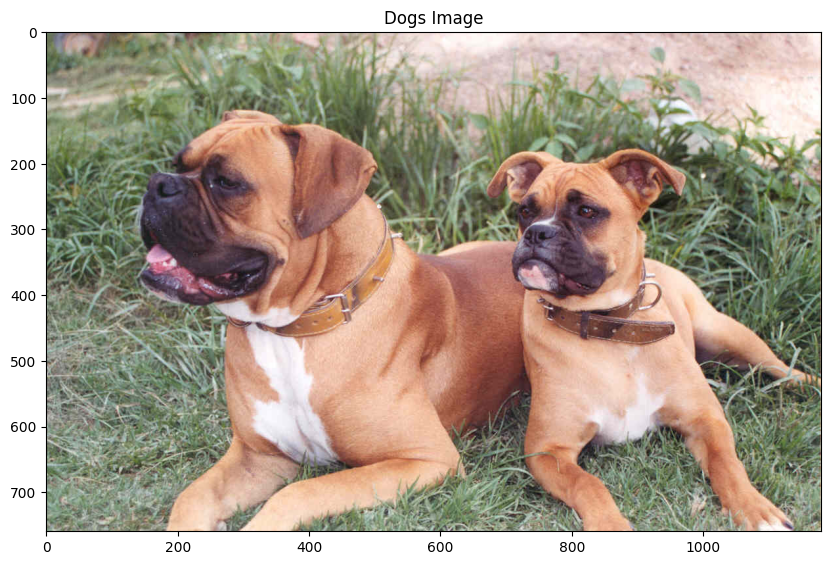

Image size: 2690400


In [5]:
# Load and display image
image_path = "/home/copter/jetson_benchmark/images/dogs.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('on')
plt.title("Dogs Image")
plt.show()

print(f"Image size: {image.size}")

In [6]:
# ONNX & PT model configuration

checkpoint = "/home/copter/weights/chaoningzhang_mobile_sam.pt" # Adjust this path
model_type = "vit_t" # Or "vit_h", "vit_l" if using full SAM

# Instantiate the PyTorch SAM model
sam = sam_model_registry[model_type](checkpoint=checkpoint)
# sam.to(device='cpu') # Or 'cuda' if you have a GPU

model_path = "/home/copter/onnx_models/chaoningzhang_mobile_sam.onnx"
ort_session = ort.InferenceSession(model_path)

# Determine device availability
if torch.cuda.is_available():
    device = "cuda"
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)} !!")
else:
    device = "cpu"
    print("Using CPU device.")

# Set device for SAM
sam.to(device=device)
predictor = SamPredictor(sam)


predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()
image_embedding.shape


/home/copter/miniconda3/envs/MobileSAM_onnx/lib/python3.10/site-packages/mobile_sam/build_sam.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)

Using CUDA device: Orin !!


(1, 256, 64, 64)

In [7]:
# Import necessary libraries
import time
import numpy as np
import onnxruntime
from jtop import jtop # Import the jtop library

# # Assume these imports are available from your SAM setup
# # You might need to adjust based on your specific SAM library installation
# from segment_anything import sam_model_registry, SamPredictor

# --- Your ONNX & PT model configuration ---
checkpoint = "/home/copter/weights/chaoningzhang_mobile_sam.pt" # Adjust this path
model_type = "vit_t" # Or "vit_h", "vit_l" if using full SAM

# Instantiate the PyTorch SAM model
# This part is generally for creating the ONNX model or for running PyTorch inference.
# If you are only benchmarking the ONNX model, you might not strictly need to load
# the PyTorch model if you already have the ONNX model ready.
# However, `SamPredictor` depends on `sam_model_registry`, so we keep it.
device = 'cpu' # Or 'cuda' if you have a GPU and want to use it for PyTorch operations
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# Set model and onnx
model_path = "/home/copter/onnx_models/chaoningzhang_mobile_sam.onnx"
ort_session = onnxruntime.InferenceSession(model_path)

# --- Define your image here ---
# Replace this with your actual image loading
# Example: image = cv2.imread("your_image.jpg")
# Ensure 'image' is a NumPy array, e.g., (H, W, 3) in RGB or BGR
# For demonstration, let's create a dummy image:
image = np.random.randint(0, 256, size=(1024, 1024, 3), dtype=np.uint8)

print("Model and Predictor initialized.")

/home/copter/miniconda3/envs/MobileSAM_onnx/lib/python3.10/site-packages/mobile_sam/build_sam.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)

Model and Predictor initialized.


2025-07-30 15:56:51.209076806 [E:onnxruntime:Default, env.cc:226 ThreadMain] pthread_setaffinity_np failed for thread: 1321191, index: 1, mask: {9, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-07-30 15:56:51.209197412 [E:onnxruntime:Default, env.cc:226 ThreadMain] pthread_setaffinity_np failed for thread: 1321192, index: 2, mask: {8, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.


### Example point input

In [8]:
# # ...
# input_point = np.array([[430, 400]])
# input_label = np.array([1])

# onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
# onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

# onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)


# onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
# onnx_has_mask_input = np.zeros(1, dtype=np.float32)


In [9]:
# Prepare input data that remains constant across runs

predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()

input_point = np.array([[430, 400]])
input_label = np.array([1])

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

# Define the ONNX inputs dictionary outside the loop as they are constant
ort_inputs_fixed = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}



In [10]:
# Initialize jtop
# It's best to do this once and close it when you're done
jetson = jtop()
jetson.start()

def get_gpu_memory():
    # Access GPU-specific memory usage from the jtop stats
    # jtop provides values in bytes, so we convert to GB and MB
    used_bytes = jetson.memory['RAM']['used']
    used_gb = used_bytes / (1024**3)
    used_mb = used_bytes / (1024**2)
    return used_gb, used_mb

try:

    # Optional: Clear PyTorch's CUDA cache before getting baseline memory
    if device == "cuda":
        torch.cuda.empty_cache()

    # Get baseline memory before any inference-related operations
    baseline_memory_gb, baseline_memory_mb = get_gpu_memory()
    peak_memory_gb = baseline_memory_gb
    peak_memory_mb = baseline_memory_mb

    print(f"Initial GPU memory: {baseline_memory_gb:.2f} GB ({baseline_memory_mb:.2f} MB)")

    # Warm-up inference runs...
    print("Performing warm-up runs...")
    for _ in range(5):
        # Run the full ONNX inference step
        masks, iou_predictions, low_res_logits = ort_session.run(None, ort_inputs_fixed)
        
        # Check memory after each warm-up run
        current_memory_gb, current_memory_mb = get_gpu_memory()
        if current_memory_gb > peak_memory_gb:
            peak_memory_gb = current_memory_gb
            peak_memory_mb = current_memory_mb
    print("Warm-up complete.")

    num_runs = 50
    inference_times = []
    print(f"Starting {num_runs} inference runs...")

    for i in range(num_runs):
        start_time = time.time()
        
        # This is the core ONNX inference part you want to benchmark
        masks, iou_predictions, low_res_logits = ort_session.run(None, ort_inputs_fixed)
        
        # Thresholding the masks is also part of the "prediction" step
        thresholded_masks = masks > predictor.model.mask_threshold
        
        end_time = time.time()
        
        # Check memory after each inference
        current_memory_gb, current_memory_mb = get_gpu_memory()
        if current_memory_gb > peak_memory_gb:
            peak_memory_gb = current_memory_gb
            peak_memory_mb = current_memory_mb
        
        inference_times.append(end_time - start_time)
        if (i + 1) % 10 == 0:
            print(f" Run {i+1}/{num_runs} completed. Current GPU memory: {current_memory_gb:.2f} GB ({current_memory_mb:.2f} MB)")

    average_inference_time_ms = (sum(inference_times) / num_runs) * 1000
    print(f"\nAverage Inference Speed (ONNX CUDA): {average_inference_time_ms:.2f} ms per image")
    print(f"Raw ONNX prediction shapes: masks: {masks.shape}, iou_predictions: {iou_predictions.shape}, low_res_logits: {low_res_logits.shape}")
    print(f"Baseline GPU memory: {baseline_memory_gb:.2f} GB ({baseline_memory_mb:.2f} MB)")
    print(f"Peak GPU memory usage: {peak_memory_gb:.2f} GB ({peak_memory_mb:.2f} MB)")
    print(f"Memory increase: {peak_memory_gb - baseline_memory_gb:.2f} GB ({peak_memory_mb - baseline_memory_mb:.2f} MB)")

finally:
    # Always make sure to close the jtop instance to release resources
    jetson.close()
    print("\njtop closed.")

Initial GPU memory: 0.02 GB (23.62 MB)
Performing warm-up runs...
Warm-up complete.
Starting 50 inference runs...
 Run 10/50 completed. Current GPU memory: 0.02 GB (23.73 MB)
 Run 20/50 completed. Current GPU memory: 0.02 GB (23.74 MB)
 Run 30/50 completed. Current GPU memory: 0.02 GB (23.73 MB)
 Run 40/50 completed. Current GPU memory: 0.02 GB (23.75 MB)
 Run 50/50 completed. Current GPU memory: 0.02 GB (23.75 MB)

Average Inference Speed (ONNX CUDA): 126.07 ms per image
Raw ONNX prediction shapes: masks: (1, 4, 1024, 1024), iou_predictions: (1, 4), low_res_logits: (1, 4, 256, 256)
Baseline GPU memory: 0.02 GB (23.62 MB)
Peak GPU memory usage: 0.02 GB (23.75 MB)
Memory increase: 0.00 GB (0.13 MB)

jtop closed.
